# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 36kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

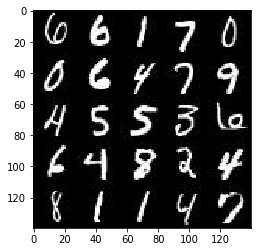

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

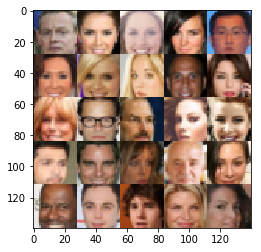

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name='input_real')
    input_fake = tf.placeholder(tf.float32, shape = (None, z_dim),name='input_fake')
    
    
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return input_real, input_fake, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        
        
        flat = tf.reshape(relu3,(-1,4*4*512))
        
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z,4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        bn1 = tf.layers.batch_normalization(x1,training = is_train)
        relu1 = tf.maximum(0.2 * bn1, bn1)
        
        x2 = tf.image.resize_images(relu1, size=[7, 7])
        x2 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2,training = is_train)
        relu2 = tf.maximum(0.2* bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training= is_train)
        relu3 = tf.maximum(0.2* bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=1,padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
## Viewing the data dimensions 
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
mnist_dataset.shape

(60000, 28, 28, 1)

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_fake, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    steps = 0
    
    #print_every=10
    #show_every=100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                #Running Optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                
                #Printing losses out at the end of every 10 batches
                if steps % 10 == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = sess.run(d_loss, {input_fake: batch_z, input_real: batch_images})
                        train_loss_g = sess.run(g_loss, {input_fake: batch_z})

                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "{} steps...".format(steps),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_fake, data_shape[3], data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... 10 steps... Discriminator Loss: 0.0000... Generator Loss: 19.7949
Epoch 1/2... 20 steps... Discriminator Loss: 0.0008... Generator Loss: 10.1026
Epoch 1/2... 30 steps... Discriminator Loss: 0.0001... Generator Loss: 9.9073
Epoch 1/2... 40 steps... Discriminator Loss: 0.0007... Generator Loss: 7.2561
Epoch 1/2... 50 steps... Discriminator Loss: 0.0004... Generator Loss: 7.8347
Epoch 1/2... 60 steps... Discriminator Loss: 0.0008... Generator Loss: 7.1386
Epoch 1/2... 70 steps... Discriminator Loss: 0.0009... Generator Loss: 6.9856
Epoch 1/2... 80 steps... Discriminator Loss: 0.0006... Generator Loss: 7.4748
Epoch 1/2... 90 steps... Discriminator Loss: 0.2546... Generator Loss: 5.8937
Epoch 1/2... 100 steps... Discriminator Loss: 5.3607... Generator Loss: 0.0227


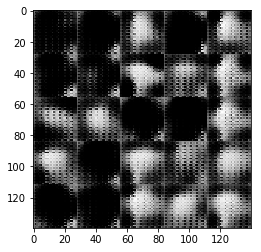

Epoch 1/2... 110 steps... Discriminator Loss: 2.0414... Generator Loss: 0.8417
Epoch 1/2... 120 steps... Discriminator Loss: 0.5046... Generator Loss: 3.6572
Epoch 1/2... 130 steps... Discriminator Loss: 1.0330... Generator Loss: 0.9014
Epoch 1/2... 140 steps... Discriminator Loss: 0.5748... Generator Loss: 2.6431
Epoch 1/2... 150 steps... Discriminator Loss: 2.0378... Generator Loss: 0.8184
Epoch 1/2... 160 steps... Discriminator Loss: 0.1595... Generator Loss: 3.4918
Epoch 1/2... 170 steps... Discriminator Loss: 0.5630... Generator Loss: 1.6615
Epoch 1/2... 180 steps... Discriminator Loss: 0.1009... Generator Loss: 4.2374
Epoch 1/2... 190 steps... Discriminator Loss: 0.1009... Generator Loss: 5.0330
Epoch 1/2... 200 steps... Discriminator Loss: 0.1224... Generator Loss: 4.6700


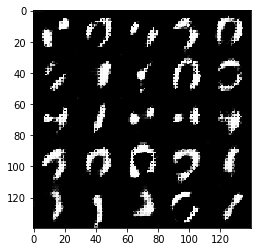

Epoch 1/2... 210 steps... Discriminator Loss: 0.2712... Generator Loss: 2.6536
Epoch 1/2... 220 steps... Discriminator Loss: 1.0577... Generator Loss: 0.8709
Epoch 1/2... 230 steps... Discriminator Loss: 1.3685... Generator Loss: 4.1230
Epoch 1/2... 240 steps... Discriminator Loss: 1.7994... Generator Loss: 5.3034
Epoch 1/2... 250 steps... Discriminator Loss: 0.9021... Generator Loss: 4.6805
Epoch 1/2... 260 steps... Discriminator Loss: 0.3425... Generator Loss: 2.4786
Epoch 1/2... 270 steps... Discriminator Loss: 0.9877... Generator Loss: 0.8363
Epoch 1/2... 280 steps... Discriminator Loss: 0.7004... Generator Loss: 2.4836
Epoch 1/2... 290 steps... Discriminator Loss: 0.1448... Generator Loss: 2.8511
Epoch 1/2... 300 steps... Discriminator Loss: 1.2590... Generator Loss: 0.6727


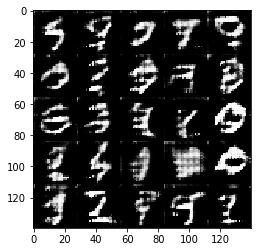

Epoch 1/2... 310 steps... Discriminator Loss: 1.3529... Generator Loss: 0.5608
Epoch 1/2... 320 steps... Discriminator Loss: 1.5860... Generator Loss: 0.4589
Epoch 1/2... 330 steps... Discriminator Loss: 1.0045... Generator Loss: 0.8773
Epoch 1/2... 340 steps... Discriminator Loss: 1.6632... Generator Loss: 3.2668
Epoch 1/2... 350 steps... Discriminator Loss: 1.0164... Generator Loss: 0.8494
Epoch 1/2... 360 steps... Discriminator Loss: 0.8826... Generator Loss: 1.0580
Epoch 1/2... 370 steps... Discriminator Loss: 1.3936... Generator Loss: 0.4903
Epoch 1/2... 380 steps... Discriminator Loss: 1.6602... Generator Loss: 3.5763
Epoch 1/2... 390 steps... Discriminator Loss: 1.1844... Generator Loss: 0.5619
Epoch 1/2... 400 steps... Discriminator Loss: 1.3478... Generator Loss: 3.7624


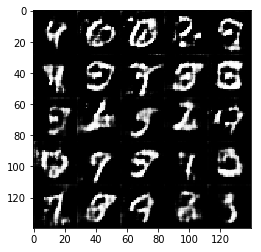

Epoch 1/2... 410 steps... Discriminator Loss: 0.8411... Generator Loss: 1.2274
Epoch 1/2... 420 steps... Discriminator Loss: 1.0037... Generator Loss: 0.6663
Epoch 1/2... 430 steps... Discriminator Loss: 0.9709... Generator Loss: 0.6918
Epoch 1/2... 440 steps... Discriminator Loss: 1.0075... Generator Loss: 2.1962
Epoch 1/2... 450 steps... Discriminator Loss: 2.4264... Generator Loss: 0.1648
Epoch 1/2... 460 steps... Discriminator Loss: 0.9496... Generator Loss: 0.9606
Epoch 2/2... 470 steps... Discriminator Loss: 0.6499... Generator Loss: 1.2493
Epoch 2/2... 480 steps... Discriminator Loss: 1.3401... Generator Loss: 0.4871
Epoch 2/2... 490 steps... Discriminator Loss: 1.0663... Generator Loss: 0.6990
Epoch 2/2... 500 steps... Discriminator Loss: 0.9748... Generator Loss: 0.6832


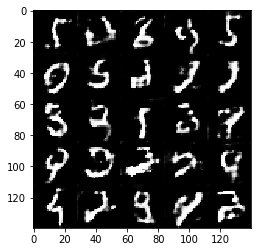

Epoch 2/2... 510 steps... Discriminator Loss: 2.5686... Generator Loss: 0.1471
Epoch 2/2... 520 steps... Discriminator Loss: 1.1526... Generator Loss: 0.9975
Epoch 2/2... 530 steps... Discriminator Loss: 1.4778... Generator Loss: 0.4365
Epoch 2/2... 540 steps... Discriminator Loss: 0.8754... Generator Loss: 0.9497
Epoch 2/2... 550 steps... Discriminator Loss: 0.8223... Generator Loss: 1.4448
Epoch 2/2... 560 steps... Discriminator Loss: 0.9435... Generator Loss: 0.9322
Epoch 2/2... 570 steps... Discriminator Loss: 0.9447... Generator Loss: 1.0314
Epoch 2/2... 580 steps... Discriminator Loss: 1.6561... Generator Loss: 0.3411
Epoch 2/2... 590 steps... Discriminator Loss: 0.9289... Generator Loss: 1.4219
Epoch 2/2... 600 steps... Discriminator Loss: 0.7981... Generator Loss: 1.1124


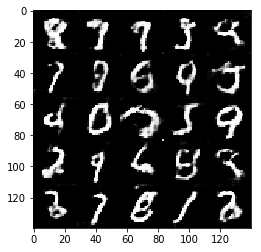

Epoch 2/2... 610 steps... Discriminator Loss: 0.5418... Generator Loss: 1.4504
Epoch 2/2... 620 steps... Discriminator Loss: 0.6832... Generator Loss: 1.0581
Epoch 2/2... 630 steps... Discriminator Loss: 1.3986... Generator Loss: 0.5427
Epoch 2/2... 640 steps... Discriminator Loss: 0.9337... Generator Loss: 0.8022
Epoch 2/2... 650 steps... Discriminator Loss: 1.5417... Generator Loss: 0.3936
Epoch 2/2... 660 steps... Discriminator Loss: 0.8464... Generator Loss: 1.0200
Epoch 2/2... 670 steps... Discriminator Loss: 0.8542... Generator Loss: 0.8460
Epoch 2/2... 680 steps... Discriminator Loss: 0.9011... Generator Loss: 2.1252
Epoch 2/2... 690 steps... Discriminator Loss: 1.4009... Generator Loss: 0.4627
Epoch 2/2... 700 steps... Discriminator Loss: 1.3540... Generator Loss: 0.7247


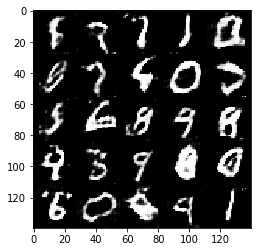

Epoch 2/2... 710 steps... Discriminator Loss: 0.9248... Generator Loss: 0.9290
Epoch 2/2... 720 steps... Discriminator Loss: 2.4649... Generator Loss: 4.2967
Epoch 2/2... 730 steps... Discriminator Loss: 1.7220... Generator Loss: 3.5254
Epoch 2/2... 740 steps... Discriminator Loss: 1.2380... Generator Loss: 2.7130
Epoch 2/2... 750 steps... Discriminator Loss: 0.6372... Generator Loss: 1.6836
Epoch 2/2... 760 steps... Discriminator Loss: 1.3188... Generator Loss: 0.5374
Epoch 2/2... 770 steps... Discriminator Loss: 1.4390... Generator Loss: 0.4891
Epoch 2/2... 780 steps... Discriminator Loss: 0.8253... Generator Loss: 1.0063
Epoch 2/2... 790 steps... Discriminator Loss: 1.0901... Generator Loss: 2.3946
Epoch 2/2... 800 steps... Discriminator Loss: 0.9740... Generator Loss: 1.1591


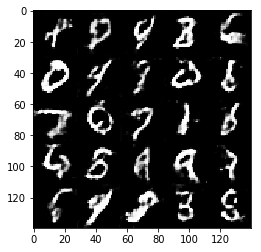

Epoch 2/2... 810 steps... Discriminator Loss: 1.3660... Generator Loss: 0.5767
Epoch 2/2... 820 steps... Discriminator Loss: 1.0828... Generator Loss: 1.5913
Epoch 2/2... 830 steps... Discriminator Loss: 0.7817... Generator Loss: 1.3739
Epoch 2/2... 840 steps... Discriminator Loss: 0.8113... Generator Loss: 1.2413
Epoch 2/2... 850 steps... Discriminator Loss: 0.8469... Generator Loss: 1.3851
Epoch 2/2... 860 steps... Discriminator Loss: 0.9519... Generator Loss: 2.1573
Epoch 2/2... 870 steps... Discriminator Loss: 0.7108... Generator Loss: 1.4839
Epoch 2/2... 880 steps... Discriminator Loss: 0.7592... Generator Loss: 1.2598
Epoch 2/2... 890 steps... Discriminator Loss: 0.8480... Generator Loss: 1.2208
Epoch 2/2... 900 steps... Discriminator Loss: 0.7362... Generator Loss: 1.1666


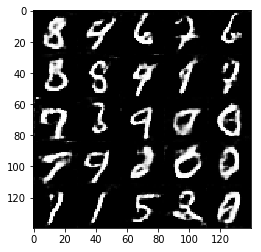

Epoch 2/2... 910 steps... Discriminator Loss: 0.7853... Generator Loss: 1.7017
Epoch 2/2... 920 steps... Discriminator Loss: 1.1862... Generator Loss: 0.6168
Epoch 2/2... 930 steps... Discriminator Loss: 1.4139... Generator Loss: 2.0115


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... 10 steps... Discriminator Loss: 0.0002... Generator Loss: 20.9284
Epoch 1/2... 20 steps... Discriminator Loss: 0.0148... Generator Loss: 12.4233
Epoch 1/2... 30 steps... Discriminator Loss: 0.0360... Generator Loss: 4.5608
Epoch 1/2... 40 steps... Discriminator Loss: 1.9911... Generator Loss: 0.5188
Epoch 1/2... 50 steps... Discriminator Loss: 0.2231... Generator Loss: 2.6744
Epoch 1/2... 60 steps... Discriminator Loss: 4.7371... Generator Loss: 15.5062
Epoch 1/2... 70 steps... Discriminator Loss: 2.2562... Generator Loss: 12.1010
Epoch 1/2... 80 steps... Discriminator Loss: 1.4414... Generator Loss: 0.6723
Epoch 1/2... 90 steps... Discriminator Loss: 0.2625... Generator Loss: 2.4698
Epoch 1/2... 100 steps... Discriminator Loss: 0.2322... Generator Loss: 5.8612


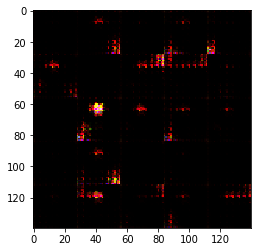

Epoch 1/2... 110 steps... Discriminator Loss: 0.6790... Generator Loss: 1.0232
Epoch 1/2... 120 steps... Discriminator Loss: 0.1035... Generator Loss: 5.1933
Epoch 1/2... 130 steps... Discriminator Loss: 2.1210... Generator Loss: 0.1606
Epoch 1/2... 140 steps... Discriminator Loss: 1.4282... Generator Loss: 6.4676
Epoch 1/2... 150 steps... Discriminator Loss: 0.4083... Generator Loss: 1.4561
Epoch 1/2... 160 steps... Discriminator Loss: 1.6723... Generator Loss: 1.6698
Epoch 1/2... 170 steps... Discriminator Loss: 1.4675... Generator Loss: 2.6059
Epoch 1/2... 180 steps... Discriminator Loss: 0.9706... Generator Loss: 0.7340
Epoch 1/2... 190 steps... Discriminator Loss: 1.4359... Generator Loss: 0.7831
Epoch 1/2... 200 steps... Discriminator Loss: 1.0436... Generator Loss: 0.7327


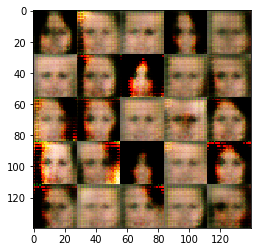

Epoch 1/2... 210 steps... Discriminator Loss: 1.2894... Generator Loss: 0.8159
Epoch 1/2... 220 steps... Discriminator Loss: 1.5414... Generator Loss: 0.5992
Epoch 1/2... 230 steps... Discriminator Loss: 1.8450... Generator Loss: 0.3478
Epoch 1/2... 240 steps... Discriminator Loss: 0.5277... Generator Loss: 1.2218
Epoch 1/2... 250 steps... Discriminator Loss: 1.6431... Generator Loss: 0.6481
Epoch 1/2... 260 steps... Discriminator Loss: 1.1950... Generator Loss: 0.7184
Epoch 1/2... 270 steps... Discriminator Loss: 1.0233... Generator Loss: 1.6235
Epoch 1/2... 280 steps... Discriminator Loss: 0.6562... Generator Loss: 1.2712
Epoch 1/2... 290 steps... Discriminator Loss: 0.7951... Generator Loss: 0.9471
Epoch 1/2... 300 steps... Discriminator Loss: 3.1270... Generator Loss: 2.5423


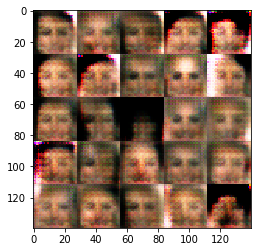

Epoch 1/2... 310 steps... Discriminator Loss: 1.3824... Generator Loss: 0.6866
Epoch 1/2... 320 steps... Discriminator Loss: 1.1281... Generator Loss: 1.0090
Epoch 1/2... 330 steps... Discriminator Loss: 1.2904... Generator Loss: 0.8836
Epoch 1/2... 340 steps... Discriminator Loss: 0.9444... Generator Loss: 1.0082
Epoch 1/2... 350 steps... Discriminator Loss: 1.2709... Generator Loss: 0.6975
Epoch 1/2... 360 steps... Discriminator Loss: 1.0324... Generator Loss: 1.1379
Epoch 1/2... 370 steps... Discriminator Loss: 1.4388... Generator Loss: 0.7265
Epoch 1/2... 380 steps... Discriminator Loss: 0.9824... Generator Loss: 1.7654
Epoch 1/2... 390 steps... Discriminator Loss: 1.0759... Generator Loss: 0.7862
Epoch 1/2... 400 steps... Discriminator Loss: 1.7055... Generator Loss: 1.5926


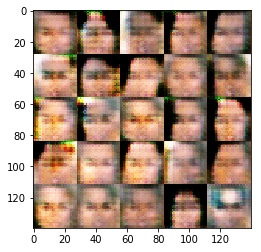

Epoch 1/2... 410 steps... Discriminator Loss: 0.4603... Generator Loss: 2.2357
Epoch 1/2... 420 steps... Discriminator Loss: 0.5379... Generator Loss: 1.2849
Epoch 1/2... 430 steps... Discriminator Loss: 4.6859... Generator Loss: 4.9103
Epoch 1/2... 440 steps... Discriminator Loss: 1.3396... Generator Loss: 0.8694
Epoch 1/2... 450 steps... Discriminator Loss: 1.0235... Generator Loss: 1.0035
Epoch 1/2... 460 steps... Discriminator Loss: 1.4075... Generator Loss: 0.8550
Epoch 1/2... 470 steps... Discriminator Loss: 0.8805... Generator Loss: 1.0560
Epoch 1/2... 480 steps... Discriminator Loss: 1.5358... Generator Loss: 0.3266
Epoch 1/2... 490 steps... Discriminator Loss: 0.9179... Generator Loss: 0.9763
Epoch 1/2... 500 steps... Discriminator Loss: 0.7747... Generator Loss: 1.8733


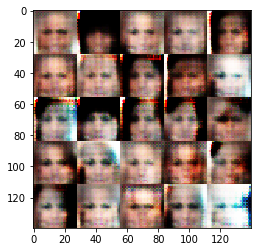

Epoch 1/2... 510 steps... Discriminator Loss: 0.8935... Generator Loss: 1.1288
Epoch 1/2... 520 steps... Discriminator Loss: 1.2138... Generator Loss: 0.9332
Epoch 1/2... 530 steps... Discriminator Loss: 1.1797... Generator Loss: 1.1687
Epoch 1/2... 540 steps... Discriminator Loss: 0.8429... Generator Loss: 1.1448
Epoch 1/2... 550 steps... Discriminator Loss: 1.0531... Generator Loss: 0.9784
Epoch 1/2... 560 steps... Discriminator Loss: 0.9818... Generator Loss: 2.3118
Epoch 1/2... 570 steps... Discriminator Loss: 1.1560... Generator Loss: 0.9014
Epoch 1/2... 580 steps... Discriminator Loss: 0.7330... Generator Loss: 1.1155
Epoch 1/2... 590 steps... Discriminator Loss: 1.3533... Generator Loss: 2.2805
Epoch 1/2... 600 steps... Discriminator Loss: 0.8382... Generator Loss: 0.8270


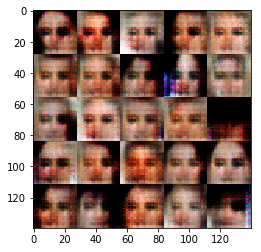

Epoch 1/2... 610 steps... Discriminator Loss: 1.3681... Generator Loss: 0.4481
Epoch 1/2... 620 steps... Discriminator Loss: 1.3644... Generator Loss: 0.6437
Epoch 1/2... 630 steps... Discriminator Loss: 1.5013... Generator Loss: 0.3918
Epoch 1/2... 640 steps... Discriminator Loss: 1.0381... Generator Loss: 1.9927
Epoch 1/2... 650 steps... Discriminator Loss: 1.2211... Generator Loss: 0.4746
Epoch 1/2... 660 steps... Discriminator Loss: 0.9133... Generator Loss: 1.2069
Epoch 1/2... 670 steps... Discriminator Loss: 1.3141... Generator Loss: 0.4668
Epoch 1/2... 680 steps... Discriminator Loss: 0.7631... Generator Loss: 1.0719
Epoch 1/2... 690 steps... Discriminator Loss: 1.4297... Generator Loss: 0.4195
Epoch 1/2... 700 steps... Discriminator Loss: 0.7646... Generator Loss: 1.2628


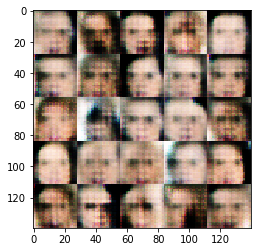

Epoch 1/2... 710 steps... Discriminator Loss: 1.5611... Generator Loss: 0.3002
Epoch 1/2... 720 steps... Discriminator Loss: 0.9571... Generator Loss: 1.0861
Epoch 1/2... 730 steps... Discriminator Loss: 0.7371... Generator Loss: 1.4209
Epoch 1/2... 740 steps... Discriminator Loss: 1.5621... Generator Loss: 0.3612
Epoch 1/2... 750 steps... Discriminator Loss: 1.4153... Generator Loss: 0.7651
Epoch 1/2... 760 steps... Discriminator Loss: 0.9349... Generator Loss: 0.7780
Epoch 1/2... 770 steps... Discriminator Loss: 1.3699... Generator Loss: 0.4625
Epoch 1/2... 780 steps... Discriminator Loss: 1.1868... Generator Loss: 0.8897
Epoch 1/2... 790 steps... Discriminator Loss: 1.7928... Generator Loss: 0.3046
Epoch 1/2... 800 steps... Discriminator Loss: 1.0966... Generator Loss: 0.9950


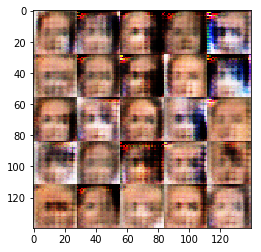

Epoch 1/2... 810 steps... Discriminator Loss: 1.5293... Generator Loss: 0.3265
Epoch 1/2... 820 steps... Discriminator Loss: 1.4212... Generator Loss: 0.8230
Epoch 1/2... 830 steps... Discriminator Loss: 1.1169... Generator Loss: 0.9424
Epoch 1/2... 840 steps... Discriminator Loss: 1.4187... Generator Loss: 0.7859
Epoch 1/2... 850 steps... Discriminator Loss: 1.5669... Generator Loss: 0.3647
Epoch 1/2... 860 steps... Discriminator Loss: 1.2975... Generator Loss: 0.5083
Epoch 1/2... 870 steps... Discriminator Loss: 1.3261... Generator Loss: 0.4452
Epoch 1/2... 880 steps... Discriminator Loss: 1.4742... Generator Loss: 0.5270
Epoch 1/2... 890 steps... Discriminator Loss: 1.2496... Generator Loss: 0.4736
Epoch 1/2... 900 steps... Discriminator Loss: 1.6869... Generator Loss: 0.5517


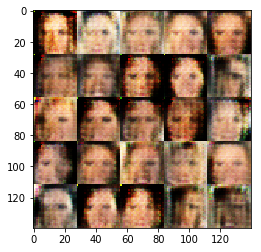

Epoch 1/2... 910 steps... Discriminator Loss: 1.0942... Generator Loss: 0.9808
Epoch 1/2... 920 steps... Discriminator Loss: 1.0526... Generator Loss: 1.6757
Epoch 1/2... 930 steps... Discriminator Loss: 1.4648... Generator Loss: 1.4789
Epoch 1/2... 940 steps... Discriminator Loss: 1.1770... Generator Loss: 1.7247
Epoch 1/2... 950 steps... Discriminator Loss: 1.1741... Generator Loss: 0.6363
Epoch 1/2... 960 steps... Discriminator Loss: 1.2106... Generator Loss: 0.8960
Epoch 1/2... 970 steps... Discriminator Loss: 1.2044... Generator Loss: 1.1471
Epoch 1/2... 980 steps... Discriminator Loss: 1.2291... Generator Loss: 0.5740
Epoch 1/2... 990 steps... Discriminator Loss: 2.9816... Generator Loss: 0.0652
Epoch 1/2... 1000 steps... Discriminator Loss: 0.9646... Generator Loss: 0.8005


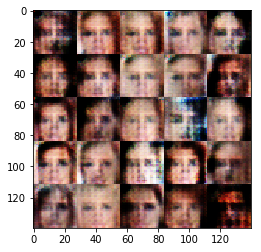

Epoch 1/2... 1010 steps... Discriminator Loss: 1.7969... Generator Loss: 2.0436
Epoch 1/2... 1020 steps... Discriminator Loss: 2.3785... Generator Loss: 0.1366
Epoch 1/2... 1030 steps... Discriminator Loss: 1.3606... Generator Loss: 0.9856
Epoch 1/2... 1040 steps... Discriminator Loss: 0.9019... Generator Loss: 1.2164
Epoch 1/2... 1050 steps... Discriminator Loss: 1.8139... Generator Loss: 0.2682
Epoch 1/2... 1060 steps... Discriminator Loss: 1.2521... Generator Loss: 1.1652
Epoch 1/2... 1070 steps... Discriminator Loss: 0.6038... Generator Loss: 2.6934
Epoch 1/2... 1080 steps... Discriminator Loss: 1.1904... Generator Loss: 1.3954
Epoch 1/2... 1090 steps... Discriminator Loss: 1.6370... Generator Loss: 0.3579
Epoch 1/2... 1100 steps... Discriminator Loss: 1.4855... Generator Loss: 0.5492


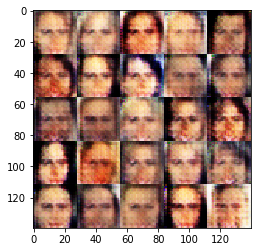

Epoch 1/2... 1110 steps... Discriminator Loss: 1.3114... Generator Loss: 0.7316
Epoch 1/2... 1120 steps... Discriminator Loss: 1.3669... Generator Loss: 0.4432
Epoch 1/2... 1130 steps... Discriminator Loss: 1.6998... Generator Loss: 2.9972
Epoch 1/2... 1140 steps... Discriminator Loss: 1.2559... Generator Loss: 0.5136
Epoch 1/2... 1150 steps... Discriminator Loss: 1.4954... Generator Loss: 1.8976
Epoch 1/2... 1160 steps... Discriminator Loss: 1.5178... Generator Loss: 0.3693
Epoch 1/2... 1170 steps... Discriminator Loss: 1.7265... Generator Loss: 0.3633
Epoch 1/2... 1180 steps... Discriminator Loss: 1.2948... Generator Loss: 1.7704
Epoch 1/2... 1190 steps... Discriminator Loss: 0.9979... Generator Loss: 0.7302
Epoch 1/2... 1200 steps... Discriminator Loss: 1.4674... Generator Loss: 1.6436


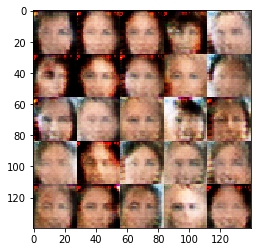

Epoch 1/2... 1210 steps... Discriminator Loss: 1.4175... Generator Loss: 1.7682
Epoch 1/2... 1220 steps... Discriminator Loss: 1.4034... Generator Loss: 2.0524
Epoch 1/2... 1230 steps... Discriminator Loss: 0.9608... Generator Loss: 1.0492
Epoch 1/2... 1240 steps... Discriminator Loss: 1.2840... Generator Loss: 1.1653
Epoch 1/2... 1250 steps... Discriminator Loss: 0.8275... Generator Loss: 0.9368
Epoch 1/2... 1260 steps... Discriminator Loss: 1.2549... Generator Loss: 0.9511
Epoch 1/2... 1270 steps... Discriminator Loss: 1.5169... Generator Loss: 1.4797
Epoch 1/2... 1280 steps... Discriminator Loss: 1.2678... Generator Loss: 1.1681
Epoch 1/2... 1290 steps... Discriminator Loss: 1.0966... Generator Loss: 0.7038
Epoch 1/2... 1300 steps... Discriminator Loss: 1.4269... Generator Loss: 0.5577


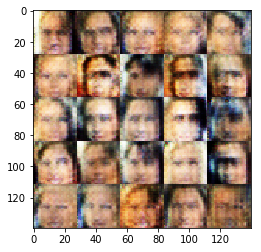

Epoch 1/2... 1310 steps... Discriminator Loss: 1.0780... Generator Loss: 0.6230
Epoch 1/2... 1320 steps... Discriminator Loss: 1.4221... Generator Loss: 1.5566
Epoch 1/2... 1330 steps... Discriminator Loss: 1.1971... Generator Loss: 0.6165
Epoch 1/2... 1340 steps... Discriminator Loss: 1.6691... Generator Loss: 0.3646
Epoch 1/2... 1350 steps... Discriminator Loss: 1.2394... Generator Loss: 0.5159
Epoch 1/2... 1360 steps... Discriminator Loss: 1.4760... Generator Loss: 0.4068
Epoch 1/2... 1370 steps... Discriminator Loss: 1.2564... Generator Loss: 1.1028
Epoch 1/2... 1380 steps... Discriminator Loss: 1.2665... Generator Loss: 0.6105
Epoch 1/2... 1390 steps... Discriminator Loss: 2.0625... Generator Loss: 0.2509
Epoch 1/2... 1400 steps... Discriminator Loss: 1.5766... Generator Loss: 1.8054


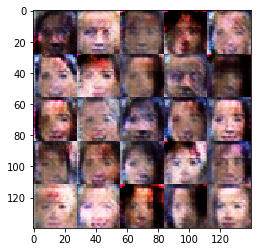

Epoch 1/2... 1410 steps... Discriminator Loss: 1.1914... Generator Loss: 0.6419
Epoch 1/2... 1420 steps... Discriminator Loss: 1.4181... Generator Loss: 0.5310
Epoch 1/2... 1430 steps... Discriminator Loss: 1.2032... Generator Loss: 0.8148
Epoch 1/2... 1440 steps... Discriminator Loss: 1.4144... Generator Loss: 1.5264
Epoch 1/2... 1450 steps... Discriminator Loss: 0.9266... Generator Loss: 1.3212
Epoch 1/2... 1460 steps... Discriminator Loss: 1.1369... Generator Loss: 0.6727
Epoch 1/2... 1470 steps... Discriminator Loss: 1.3358... Generator Loss: 1.0146
Epoch 1/2... 1480 steps... Discriminator Loss: 1.4524... Generator Loss: 0.4064
Epoch 1/2... 1490 steps... Discriminator Loss: 1.3551... Generator Loss: 0.7650
Epoch 1/2... 1500 steps... Discriminator Loss: 0.9902... Generator Loss: 0.9785


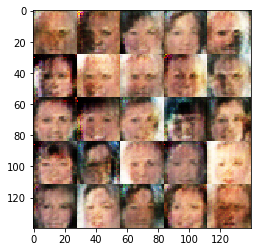

Epoch 1/2... 1510 steps... Discriminator Loss: 1.2521... Generator Loss: 0.7790
Epoch 1/2... 1520 steps... Discriminator Loss: 1.2347... Generator Loss: 1.3176
Epoch 1/2... 1530 steps... Discriminator Loss: 1.2247... Generator Loss: 0.6675
Epoch 1/2... 1540 steps... Discriminator Loss: 1.2384... Generator Loss: 0.7549
Epoch 1/2... 1550 steps... Discriminator Loss: 0.9456... Generator Loss: 1.3740
Epoch 1/2... 1560 steps... Discriminator Loss: 1.3857... Generator Loss: 0.4043
Epoch 1/2... 1570 steps... Discriminator Loss: 1.5123... Generator Loss: 0.4100
Epoch 1/2... 1580 steps... Discriminator Loss: 1.2964... Generator Loss: 0.5548
Epoch 2/2... 1590 steps... Discriminator Loss: 1.5027... Generator Loss: 0.4549
Epoch 2/2... 1600 steps... Discriminator Loss: 1.1590... Generator Loss: 1.1024


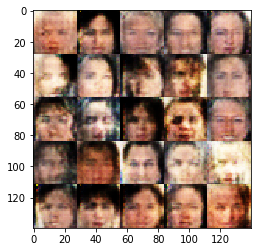

Epoch 2/2... 1610 steps... Discriminator Loss: 1.7586... Generator Loss: 0.3343
Epoch 2/2... 1620 steps... Discriminator Loss: 1.0834... Generator Loss: 0.9897
Epoch 2/2... 1630 steps... Discriminator Loss: 1.7613... Generator Loss: 1.3188
Epoch 2/2... 1640 steps... Discriminator Loss: 2.4474... Generator Loss: 2.3446
Epoch 2/2... 1650 steps... Discriminator Loss: 1.4713... Generator Loss: 1.4052
Epoch 2/2... 1660 steps... Discriminator Loss: 1.3268... Generator Loss: 0.6180
Epoch 2/2... 1670 steps... Discriminator Loss: 0.7752... Generator Loss: 1.2709
Epoch 2/2... 1680 steps... Discriminator Loss: 1.4568... Generator Loss: 0.6114
Epoch 2/2... 1690 steps... Discriminator Loss: 1.6815... Generator Loss: 0.4975
Epoch 2/2... 1700 steps... Discriminator Loss: 1.4027... Generator Loss: 0.8538


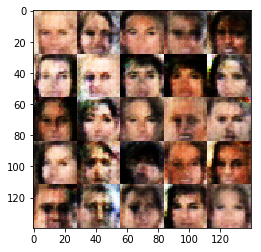

Epoch 2/2... 1710 steps... Discriminator Loss: 1.2449... Generator Loss: 0.6512
Epoch 2/2... 1720 steps... Discriminator Loss: 1.2420... Generator Loss: 0.7073
Epoch 2/2... 1730 steps... Discriminator Loss: 1.2119... Generator Loss: 0.7905
Epoch 2/2... 1740 steps... Discriminator Loss: 1.2228... Generator Loss: 0.7466
Epoch 2/2... 1750 steps... Discriminator Loss: 1.1799... Generator Loss: 0.8413
Epoch 2/2... 1760 steps... Discriminator Loss: 1.6271... Generator Loss: 0.3436
Epoch 2/2... 1770 steps... Discriminator Loss: 1.3871... Generator Loss: 1.4706
Epoch 2/2... 1780 steps... Discriminator Loss: 1.1276... Generator Loss: 0.7519
Epoch 2/2... 1790 steps... Discriminator Loss: 1.1449... Generator Loss: 0.7065
Epoch 2/2... 1800 steps... Discriminator Loss: 1.2703... Generator Loss: 0.7278


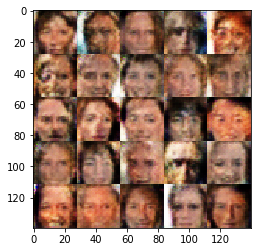

Epoch 2/2... 1810 steps... Discriminator Loss: 1.3759... Generator Loss: 1.2650
Epoch 2/2... 1820 steps... Discriminator Loss: 1.3260... Generator Loss: 0.6004
Epoch 2/2... 1830 steps... Discriminator Loss: 1.5716... Generator Loss: 1.7795
Epoch 2/2... 1840 steps... Discriminator Loss: 1.0944... Generator Loss: 0.8378
Epoch 2/2... 1850 steps... Discriminator Loss: 1.5706... Generator Loss: 1.6492
Epoch 2/2... 1860 steps... Discriminator Loss: 1.4597... Generator Loss: 0.3655
Epoch 2/2... 1870 steps... Discriminator Loss: 1.2049... Generator Loss: 0.9125
Epoch 2/2... 1880 steps... Discriminator Loss: 1.4264... Generator Loss: 1.1796
Epoch 2/2... 1890 steps... Discriminator Loss: 1.3657... Generator Loss: 0.8683
Epoch 2/2... 1900 steps... Discriminator Loss: 1.4050... Generator Loss: 0.7402


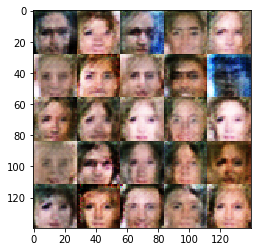

Epoch 2/2... 1910 steps... Discriminator Loss: 1.0164... Generator Loss: 0.8598
Epoch 2/2... 1920 steps... Discriminator Loss: 1.9323... Generator Loss: 0.2042
Epoch 2/2... 1930 steps... Discriminator Loss: 1.2377... Generator Loss: 0.6425
Epoch 2/2... 1940 steps... Discriminator Loss: 1.2028... Generator Loss: 0.8310
Epoch 2/2... 1950 steps... Discriminator Loss: 0.8089... Generator Loss: 1.5822
Epoch 2/2... 1960 steps... Discriminator Loss: 1.0463... Generator Loss: 1.0232
Epoch 2/2... 1970 steps... Discriminator Loss: 1.2973... Generator Loss: 0.6189
Epoch 2/2... 1980 steps... Discriminator Loss: 1.2320... Generator Loss: 0.6688
Epoch 2/2... 1990 steps... Discriminator Loss: 1.2044... Generator Loss: 0.8171
Epoch 2/2... 2000 steps... Discriminator Loss: 1.4729... Generator Loss: 1.3959


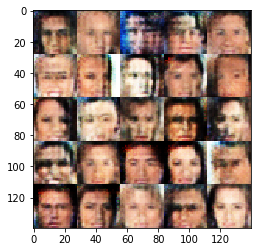

Epoch 2/2... 2010 steps... Discriminator Loss: 0.9518... Generator Loss: 0.9977
Epoch 2/2... 2020 steps... Discriminator Loss: 1.2742... Generator Loss: 0.7701
Epoch 2/2... 2030 steps... Discriminator Loss: 1.9599... Generator Loss: 1.8032
Epoch 2/2... 2040 steps... Discriminator Loss: 1.2646... Generator Loss: 0.8840
Epoch 2/2... 2050 steps... Discriminator Loss: 1.4644... Generator Loss: 0.3979
Epoch 2/2... 2060 steps... Discriminator Loss: 1.8106... Generator Loss: 0.2323
Epoch 2/2... 2070 steps... Discriminator Loss: 1.2180... Generator Loss: 0.6927
Epoch 2/2... 2080 steps... Discriminator Loss: 1.5162... Generator Loss: 0.4216
Epoch 2/2... 2090 steps... Discriminator Loss: 1.4293... Generator Loss: 1.3396
Epoch 2/2... 2100 steps... Discriminator Loss: 1.6787... Generator Loss: 0.4643


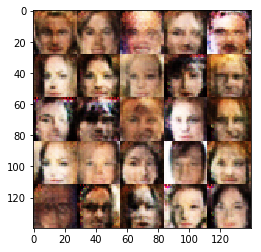

Epoch 2/2... 2110 steps... Discriminator Loss: 0.8189... Generator Loss: 1.3039
Epoch 2/2... 2120 steps... Discriminator Loss: 1.0301... Generator Loss: 1.2309
Epoch 2/2... 2130 steps... Discriminator Loss: 1.2447... Generator Loss: 1.1417
Epoch 2/2... 2140 steps... Discriminator Loss: 1.3442... Generator Loss: 0.4828
Epoch 2/2... 2150 steps... Discriminator Loss: 1.3649... Generator Loss: 0.6214
Epoch 2/2... 2160 steps... Discriminator Loss: 1.2024... Generator Loss: 0.7476
Epoch 2/2... 2170 steps... Discriminator Loss: 1.5833... Generator Loss: 0.3520
Epoch 2/2... 2180 steps... Discriminator Loss: 1.2482... Generator Loss: 0.8984
Epoch 2/2... 2190 steps... Discriminator Loss: 0.9664... Generator Loss: 1.2554
Epoch 2/2... 2200 steps... Discriminator Loss: 1.5494... Generator Loss: 0.3440


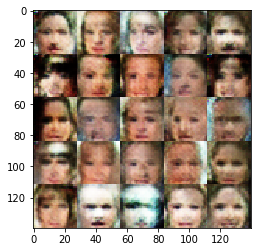

Epoch 2/2... 2210 steps... Discriminator Loss: 1.1357... Generator Loss: 1.1306
Epoch 2/2... 2220 steps... Discriminator Loss: 1.6634... Generator Loss: 0.3477
Epoch 2/2... 2230 steps... Discriminator Loss: 1.1982... Generator Loss: 0.6233
Epoch 2/2... 2240 steps... Discriminator Loss: 1.3159... Generator Loss: 1.0785
Epoch 2/2... 2250 steps... Discriminator Loss: 0.9574... Generator Loss: 1.1150
Epoch 2/2... 2260 steps... Discriminator Loss: 1.0708... Generator Loss: 1.0725
Epoch 2/2... 2270 steps... Discriminator Loss: 1.1269... Generator Loss: 0.9342
Epoch 2/2... 2280 steps... Discriminator Loss: 1.1034... Generator Loss: 0.9610
Epoch 2/2... 2290 steps... Discriminator Loss: 1.1373... Generator Loss: 0.8581
Epoch 2/2... 2300 steps... Discriminator Loss: 1.5207... Generator Loss: 1.5322


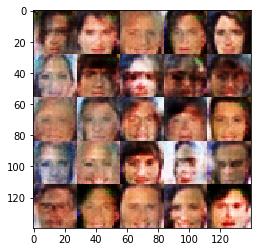

Epoch 2/2... 2310 steps... Discriminator Loss: 1.0392... Generator Loss: 1.2954
Epoch 2/2... 2320 steps... Discriminator Loss: 1.7312... Generator Loss: 1.8111
Epoch 2/2... 2330 steps... Discriminator Loss: 1.2076... Generator Loss: 1.2061
Epoch 2/2... 2340 steps... Discriminator Loss: 1.4188... Generator Loss: 2.7240
Epoch 2/2... 2350 steps... Discriminator Loss: 1.0658... Generator Loss: 1.2353
Epoch 2/2... 2360 steps... Discriminator Loss: 1.6575... Generator Loss: 1.6104
Epoch 2/2... 2370 steps... Discriminator Loss: 1.3245... Generator Loss: 0.5031
Epoch 2/2... 2380 steps... Discriminator Loss: 1.3845... Generator Loss: 0.6310
Epoch 2/2... 2390 steps... Discriminator Loss: 1.2939... Generator Loss: 0.5506
Epoch 2/2... 2400 steps... Discriminator Loss: 1.4900... Generator Loss: 0.3830


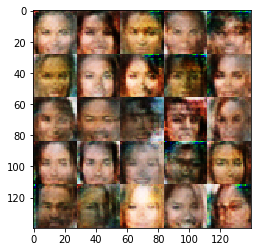

Epoch 2/2... 2410 steps... Discriminator Loss: 1.3383... Generator Loss: 0.8392
Epoch 2/2... 2420 steps... Discriminator Loss: 1.2331... Generator Loss: 0.6855
Epoch 2/2... 2430 steps... Discriminator Loss: 1.2031... Generator Loss: 0.6100
Epoch 2/2... 2440 steps... Discriminator Loss: 1.4242... Generator Loss: 0.9276
Epoch 2/2... 2450 steps... Discriminator Loss: 1.4114... Generator Loss: 0.7832
Epoch 2/2... 2460 steps... Discriminator Loss: 1.4220... Generator Loss: 1.4351
Epoch 2/2... 2470 steps... Discriminator Loss: 1.2575... Generator Loss: 0.7423
Epoch 2/2... 2480 steps... Discriminator Loss: 1.2981... Generator Loss: 0.7690
Epoch 2/2... 2490 steps... Discriminator Loss: 1.3040... Generator Loss: 0.9025
Epoch 2/2... 2500 steps... Discriminator Loss: 1.2082... Generator Loss: 0.9714


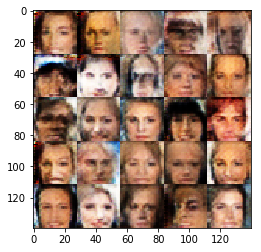

Epoch 2/2... 2510 steps... Discriminator Loss: 1.4329... Generator Loss: 0.5471
Epoch 2/2... 2520 steps... Discriminator Loss: 1.1185... Generator Loss: 1.3530
Epoch 2/2... 2530 steps... Discriminator Loss: 1.6841... Generator Loss: 0.3930
Epoch 2/2... 2540 steps... Discriminator Loss: 1.3882... Generator Loss: 0.6318
Epoch 2/2... 2550 steps... Discriminator Loss: 1.4113... Generator Loss: 1.1648
Epoch 2/2... 2560 steps... Discriminator Loss: 1.2677... Generator Loss: 1.4031
Epoch 2/2... 2570 steps... Discriminator Loss: 1.3391... Generator Loss: 0.8168
Epoch 2/2... 2580 steps... Discriminator Loss: 1.2268... Generator Loss: 0.6356
Epoch 2/2... 2590 steps... Discriminator Loss: 1.4437... Generator Loss: 0.6040
Epoch 2/2... 2600 steps... Discriminator Loss: 1.3307... Generator Loss: 0.4840


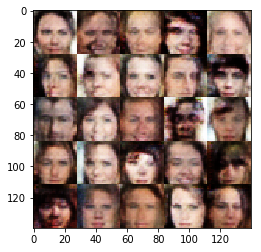

Epoch 2/2... 2610 steps... Discriminator Loss: 1.7022... Generator Loss: 0.2941
Epoch 2/2... 2620 steps... Discriminator Loss: 1.4740... Generator Loss: 0.5985
Epoch 2/2... 2630 steps... Discriminator Loss: 1.5531... Generator Loss: 0.6125
Epoch 2/2... 2640 steps... Discriminator Loss: 1.3997... Generator Loss: 0.4483
Epoch 2/2... 2650 steps... Discriminator Loss: 1.1367... Generator Loss: 0.7804
Epoch 2/2... 2660 steps... Discriminator Loss: 1.5239... Generator Loss: 0.5348
Epoch 2/2... 2670 steps... Discriminator Loss: 1.2539... Generator Loss: 0.6794
Epoch 2/2... 2680 steps... Discriminator Loss: 1.5913... Generator Loss: 0.3579
Epoch 2/2... 2690 steps... Discriminator Loss: 1.0836... Generator Loss: 1.0388
Epoch 2/2... 2700 steps... Discriminator Loss: 1.3576... Generator Loss: 1.1690


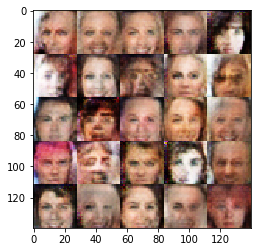

Epoch 2/2... 2710 steps... Discriminator Loss: 1.4592... Generator Loss: 1.0663
Epoch 2/2... 2720 steps... Discriminator Loss: 1.0710... Generator Loss: 0.8225
Epoch 2/2... 2730 steps... Discriminator Loss: 1.4104... Generator Loss: 0.8027
Epoch 2/2... 2740 steps... Discriminator Loss: 1.0973... Generator Loss: 1.2318
Epoch 2/2... 2750 steps... Discriminator Loss: 1.2166... Generator Loss: 0.8569
Epoch 2/2... 2760 steps... Discriminator Loss: 1.4716... Generator Loss: 0.5663
Epoch 2/2... 2770 steps... Discriminator Loss: 1.1398... Generator Loss: 1.1063
Epoch 2/2... 2780 steps... Discriminator Loss: 1.3029... Generator Loss: 0.5607
Epoch 2/2... 2790 steps... Discriminator Loss: 1.2156... Generator Loss: 0.6301
Epoch 2/2... 2800 steps... Discriminator Loss: 0.8460... Generator Loss: 0.9309


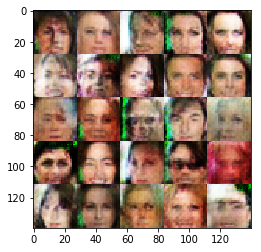

Epoch 2/2... 2810 steps... Discriminator Loss: 1.1201... Generator Loss: 0.6360
Epoch 2/2... 2820 steps... Discriminator Loss: 1.5880... Generator Loss: 0.3220
Epoch 2/2... 2830 steps... Discriminator Loss: 1.4176... Generator Loss: 0.6056
Epoch 2/2... 2840 steps... Discriminator Loss: 1.2273... Generator Loss: 0.7183
Epoch 2/2... 2850 steps... Discriminator Loss: 1.2225... Generator Loss: 0.8794
Epoch 2/2... 2860 steps... Discriminator Loss: 1.2283... Generator Loss: 0.6777
Epoch 2/2... 2870 steps... Discriminator Loss: 1.3737... Generator Loss: 0.6773
Epoch 2/2... 2880 steps... Discriminator Loss: 1.2636... Generator Loss: 0.5742
Epoch 2/2... 2890 steps... Discriminator Loss: 1.5426... Generator Loss: 0.6086
Epoch 2/2... 2900 steps... Discriminator Loss: 1.0616... Generator Loss: 1.3280


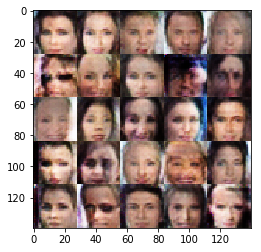

Epoch 2/2... 2910 steps... Discriminator Loss: 1.2144... Generator Loss: 0.9537
Epoch 2/2... 2920 steps... Discriminator Loss: 1.5867... Generator Loss: 1.4691
Epoch 2/2... 2930 steps... Discriminator Loss: 1.3082... Generator Loss: 0.7728
Epoch 2/2... 2940 steps... Discriminator Loss: 1.1783... Generator Loss: 0.7277
Epoch 2/2... 2950 steps... Discriminator Loss: 1.4286... Generator Loss: 0.8194
Epoch 2/2... 2960 steps... Discriminator Loss: 1.2260... Generator Loss: 0.6679
Epoch 2/2... 2970 steps... Discriminator Loss: 1.4161... Generator Loss: 0.5773
Epoch 2/2... 2980 steps... Discriminator Loss: 1.2977... Generator Loss: 1.4056
Epoch 2/2... 2990 steps... Discriminator Loss: 1.2447... Generator Loss: 0.6998
Epoch 2/2... 3000 steps... Discriminator Loss: 1.6388... Generator Loss: 1.7575


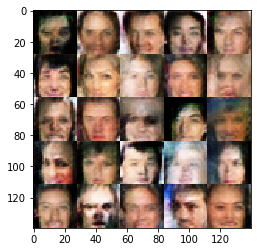

Epoch 2/2... 3010 steps... Discriminator Loss: 1.5428... Generator Loss: 0.7031
Epoch 2/2... 3020 steps... Discriminator Loss: 1.1378... Generator Loss: 0.6465
Epoch 2/2... 3030 steps... Discriminator Loss: 1.2573... Generator Loss: 0.5340
Epoch 2/2... 3040 steps... Discriminator Loss: 1.2789... Generator Loss: 0.5672
Epoch 2/2... 3050 steps... Discriminator Loss: 1.2982... Generator Loss: 1.3019
Epoch 2/2... 3060 steps... Discriminator Loss: 1.5184... Generator Loss: 0.7438
Epoch 2/2... 3070 steps... Discriminator Loss: 1.0339... Generator Loss: 0.8438
Epoch 2/2... 3080 steps... Discriminator Loss: 1.2793... Generator Loss: 0.7841
Epoch 2/2... 3090 steps... Discriminator Loss: 1.3052... Generator Loss: 0.6495
Epoch 2/2... 3100 steps... Discriminator Loss: 1.3956... Generator Loss: 0.7845


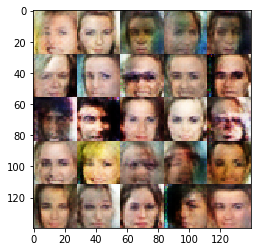

Epoch 2/2... 3110 steps... Discriminator Loss: 1.2951... Generator Loss: 0.6484
Epoch 2/2... 3120 steps... Discriminator Loss: 1.3166... Generator Loss: 1.2926
Epoch 2/2... 3130 steps... Discriminator Loss: 1.2298... Generator Loss: 1.0702
Epoch 2/2... 3140 steps... Discriminator Loss: 1.3518... Generator Loss: 0.5209
Epoch 2/2... 3150 steps... Discriminator Loss: 1.3136... Generator Loss: 0.7646
Epoch 2/2... 3160 steps... Discriminator Loss: 1.2992... Generator Loss: 0.7825


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.